In [1]:
import pandas as pd
import numpy as np
import os
import zipfile
import matplotlib.pyplot as plt
import shutil 
from tqdm import tqdm
import torch
import torchvision
from torchvision import transforms, models
import warnings
warnings.filterwarnings("ignore")

## Считывание данных из архива

In [2]:
print(os.listdir('data'))

with zipfile.ZipFile('data/plates.zip', 'r') as zip_obj:
   zip_obj.extractall('/plates/')
    
print('After zip extraction:')
print(os.listdir('/plates/'))

['Boston.csv', 'creditcard.csv', 'drug200.csv', 'lab1_data.xlsx', 'output.xlsx', 'plates.zip']
After zip extraction:
['plates', '__MACOSX']


In [3]:
data_root = '/plates/plates/'
print(os.listdir(data_root))

['.DS_Store', 'test', 'train']


In [4]:
train_dir = 'data/plates/train'
val_dir = 'data/plates/val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 21/21 [00:00<00:00, 108.26it/s]


## Нормализация изображений с помощью torchvision

In [5]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomPerspective(distortion_scale=0.1, p=0.8, interpolation=3, fill=255),   
    transforms.ColorJitter(hue=(-0.5,0.5)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(360),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [6]:
len(train_dataloader), len(train_dataset)

(5, 34)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


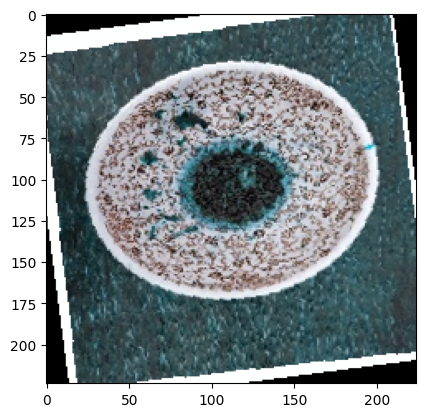

In [7]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

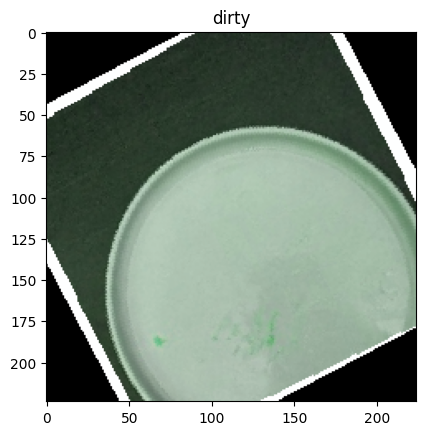

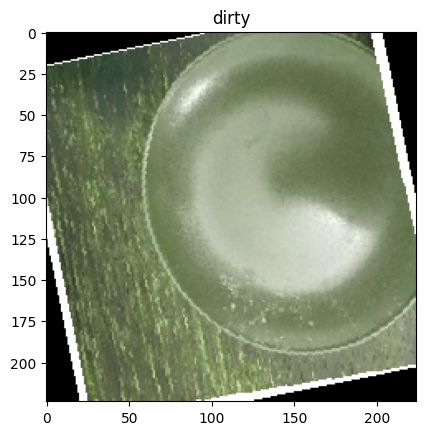

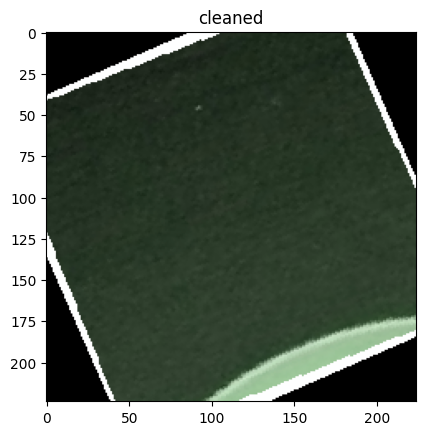

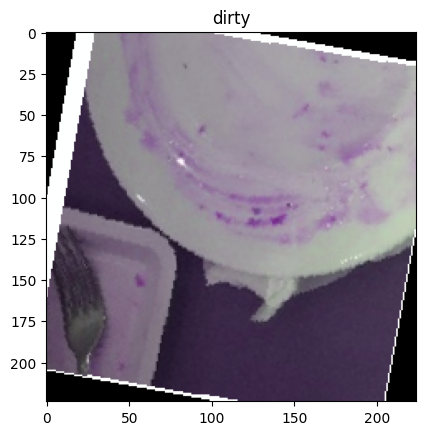

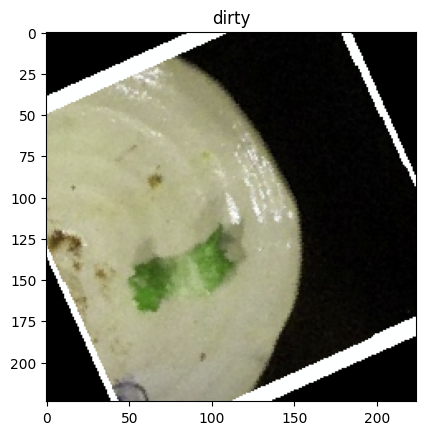

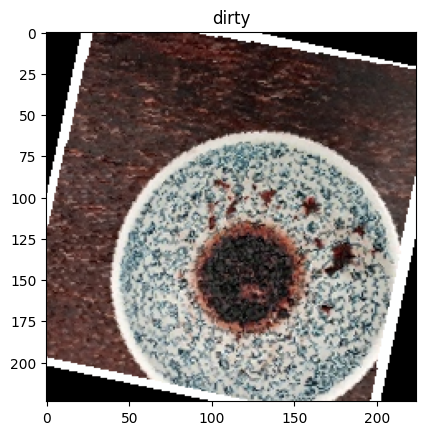

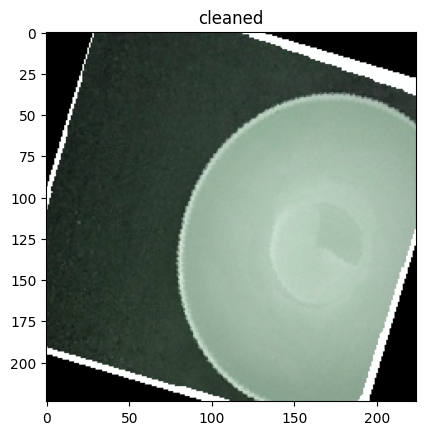

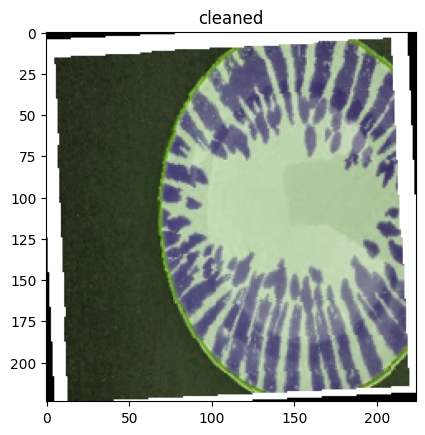

In [8]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

## Обучение модели

In [9]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            
            # we will print accuracy and loss stats
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [10]:
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

for param in model.avgpool.parameters():
    param.requires_grad = True    

for param in model.layer4.parameters():
    param.requires_grad = True

model.fc = torch.nn.Sequential(
            torch.nn.Linear(model.fc.in_features, 256),
            torch.nn.GELU(),
            torch.nn.Linear(256, 2))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\KirillPogranichny/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:35<00:00, 1.32MB/s]


In [11]:
train_model(model, loss, optimizer, scheduler, num_epochs=30);

Epoch 0/29:


100%|██████████| 5/5 [00:12<00:00,  2.52s/it]

train Loss: 0.9213 Acc: 0.4250



100%|██████████| 1/1 [00:09<00:00,  9.58s/it]

val Loss: 0.8496 Acc: 0.5000
Epoch 1/29:



100%|██████████| 5/5 [00:12<00:00,  2.54s/it]

train Loss: 0.7144 Acc: 0.5000



100%|██████████| 1/1 [00:09<00:00,  9.30s/it]

val Loss: 3.7235 Acc: 0.5000
Epoch 2/29:



100%|██████████| 5/5 [00:13<00:00,  2.65s/it]

train Loss: 0.6174 Acc: 0.7750



100%|██████████| 1/1 [00:09<00:00,  9.92s/it]

val Loss: 0.9519 Acc: 0.6667
Epoch 3/29:



100%|██████████| 5/5 [00:12<00:00,  2.54s/it]

train Loss: 0.5757 Acc: 0.6750



100%|██████████| 1/1 [00:09<00:00,  9.42s/it]

val Loss: 0.3158 Acc: 0.8333
Epoch 4/29:



100%|██████████| 5/5 [00:12<00:00,  2.56s/it]

train Loss: 0.4217 Acc: 0.8750



100%|██████████| 1/1 [00:09<00:00,  9.49s/it]

val Loss: 0.5124 Acc: 0.6667
Epoch 5/29:



100%|██████████| 5/5 [00:13<00:00,  2.65s/it]

train Loss: 0.6389 Acc: 0.8000



100%|██████████| 1/1 [00:09<00:00,  9.75s/it]

val Loss: 0.3682 Acc: 0.6667
Epoch 6/29:



100%|██████████| 5/5 [00:13<00:00,  2.61s/it]

train Loss: 0.3751 Acc: 0.8500



100%|██████████| 1/1 [00:09<00:00,  9.79s/it]

val Loss: 0.2495 Acc: 0.8333
Epoch 7/29:



100%|██████████| 5/5 [00:13<00:00,  2.61s/it]

train Loss: 0.3157 Acc: 0.9000



100%|██████████| 1/1 [00:09<00:00,  9.87s/it]

val Loss: 0.1901 Acc: 1.0000
Epoch 8/29:



100%|██████████| 5/5 [00:13<00:00,  2.61s/it]

train Loss: 0.3797 Acc: 0.8250



100%|██████████| 1/1 [00:09<00:00,  9.84s/it]

val Loss: 0.2040 Acc: 1.0000
Epoch 9/29:



100%|██████████| 5/5 [00:13<00:00,  2.75s/it]

train Loss: 0.2510 Acc: 0.9250



100%|██████████| 1/1 [00:10<00:00, 10.58s/it]

val Loss: 0.2358 Acc: 1.0000
Epoch 10/29:



100%|██████████| 5/5 [00:14<00:00,  2.99s/it]

train Loss: 0.4008 Acc: 0.7750



100%|██████████| 1/1 [00:11<00:00, 11.29s/it]

val Loss: 0.2295 Acc: 1.0000
Epoch 11/29:



100%|██████████| 5/5 [00:13<00:00,  2.79s/it]

train Loss: 0.4020 Acc: 0.8250



100%|██████████| 1/1 [00:10<00:00, 10.50s/it]

val Loss: 0.1893 Acc: 1.0000
Epoch 12/29:



100%|██████████| 5/5 [00:14<00:00,  2.81s/it]

train Loss: 0.4069 Acc: 0.8000



100%|██████████| 1/1 [00:10<00:00, 10.45s/it]

val Loss: 0.1852 Acc: 1.0000
Epoch 13/29:



100%|██████████| 5/5 [00:13<00:00,  2.79s/it]

train Loss: 0.6049 Acc: 0.7500



100%|██████████| 1/1 [00:11<00:00, 11.35s/it]

val Loss: 0.1661 Acc: 1.0000
Epoch 14/29:



100%|██████████| 5/5 [00:13<00:00,  2.78s/it]

train Loss: 0.4294 Acc: 0.8250



100%|██████████| 1/1 [00:10<00:00, 10.36s/it]

val Loss: 0.1663 Acc: 1.0000
Epoch 15/29:



100%|██████████| 5/5 [00:14<00:00,  2.81s/it]

train Loss: 0.3670 Acc: 0.8000



100%|██████████| 1/1 [00:10<00:00, 10.79s/it]

val Loss: 0.1705 Acc: 1.0000
Epoch 16/29:



100%|██████████| 5/5 [00:14<00:00,  2.80s/it]

train Loss: 0.2105 Acc: 0.9000



100%|██████████| 1/1 [00:10<00:00, 10.28s/it]

val Loss: 0.1946 Acc: 1.0000
Epoch 17/29:



100%|██████████| 5/5 [00:13<00:00,  2.78s/it]

train Loss: 0.4683 Acc: 0.8250



100%|██████████| 1/1 [00:10<00:00, 10.38s/it]

val Loss: 0.1841 Acc: 1.0000
Epoch 18/29:



100%|██████████| 5/5 [00:13<00:00,  2.75s/it]

train Loss: 0.4091 Acc: 0.8000



100%|██████████| 1/1 [00:10<00:00, 10.40s/it]

val Loss: 0.1669 Acc: 1.0000
Epoch 19/29:



100%|██████████| 5/5 [00:13<00:00,  2.74s/it]

train Loss: 0.4581 Acc: 0.8000



100%|██████████| 1/1 [00:10<00:00, 10.31s/it]

val Loss: 0.1756 Acc: 1.0000
Epoch 20/29:



100%|██████████| 5/5 [00:13<00:00,  2.77s/it]

train Loss: 0.3545 Acc: 0.8500



100%|██████████| 1/1 [00:10<00:00, 10.28s/it]

val Loss: 0.1868 Acc: 1.0000
Epoch 21/29:



100%|██████████| 5/5 [00:13<00:00,  2.79s/it]

train Loss: 0.3654 Acc: 0.8250



100%|██████████| 1/1 [00:10<00:00, 10.42s/it]

val Loss: 0.1913 Acc: 1.0000
Epoch 22/29:



100%|██████████| 5/5 [00:13<00:00,  2.74s/it]

train Loss: 0.3574 Acc: 0.8250



100%|██████████| 1/1 [00:10<00:00, 10.54s/it]

val Loss: 0.1891 Acc: 1.0000
Epoch 23/29:



100%|██████████| 5/5 [00:13<00:00,  2.78s/it]

train Loss: 0.5313 Acc: 0.7750



100%|██████████| 1/1 [00:10<00:00, 10.59s/it]

val Loss: 0.1820 Acc: 1.0000
Epoch 24/29:



100%|██████████| 5/5 [00:13<00:00,  2.77s/it]

train Loss: 0.6061 Acc: 0.6250



100%|██████████| 1/1 [00:10<00:00, 10.35s/it]

val Loss: 0.1812 Acc: 1.0000
Epoch 25/29:



100%|██████████| 5/5 [00:14<00:00,  2.93s/it]

train Loss: 0.2637 Acc: 0.8500



100%|██████████| 1/1 [00:10<00:00, 10.63s/it]

val Loss: 0.1914 Acc: 1.0000
Epoch 26/29:



100%|██████████| 5/5 [00:14<00:00,  2.82s/it]

train Loss: 0.5418 Acc: 0.8000



100%|██████████| 1/1 [00:10<00:00, 10.57s/it]

val Loss: 0.2060 Acc: 1.0000
Epoch 27/29:



100%|██████████| 5/5 [00:14<00:00,  2.81s/it]

train Loss: 0.3849 Acc: 0.8250



100%|██████████| 1/1 [00:10<00:00, 10.71s/it]

val Loss: 0.1992 Acc: 1.0000
Epoch 28/29:



100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

train Loss: 0.3287 Acc: 0.9500



100%|██████████| 1/1 [00:10<00:00, 10.56s/it]

val Loss: 0.1801 Acc: 1.0000
Epoch 29/29:



100%|██████████| 5/5 [00:14<00:00,  2.92s/it]

train Loss: 0.3153 Acc: 0.8750



100%|██████████| 1/1 [00:10<00:00, 10.85s/it]

val Loss: 0.1944 Acc: 1.0000


## Запуск модели

In [12]:
test_dir = 'data/plates/test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'data/plates/test\\unknown'

In [13]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('data/plates/test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [14]:
test_dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 744
    Root location: data/plates/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [15]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 93/93 [00:53<00:00,  1.73it/s]


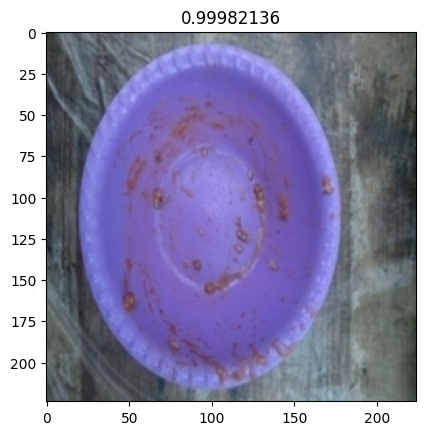

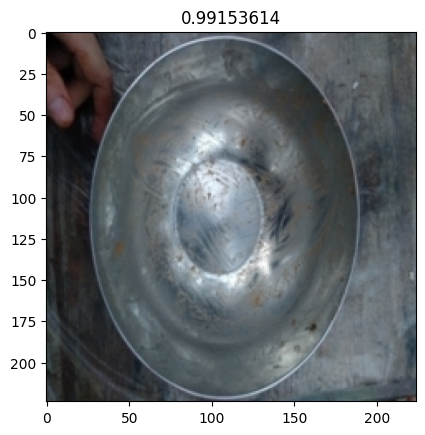

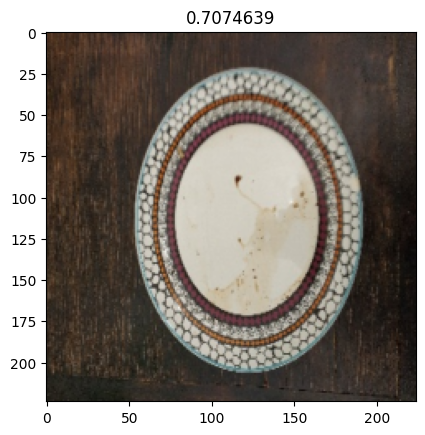

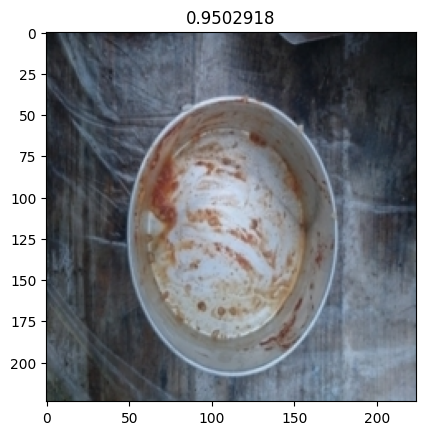

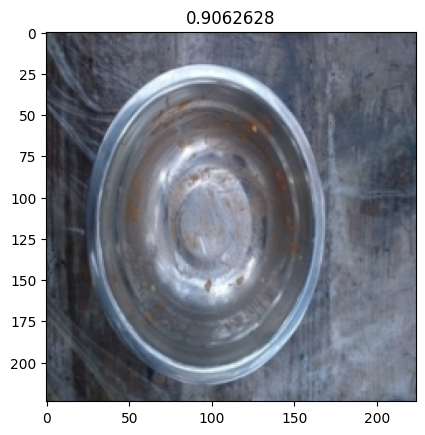

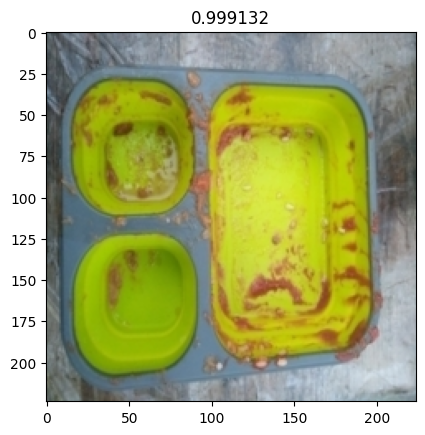

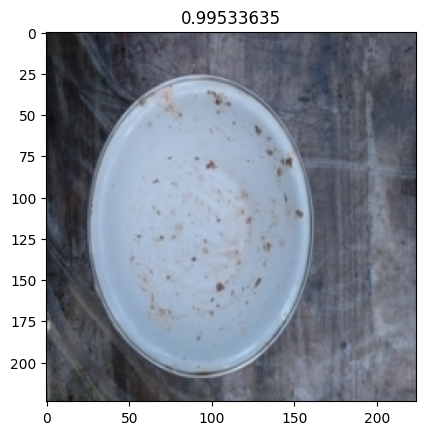

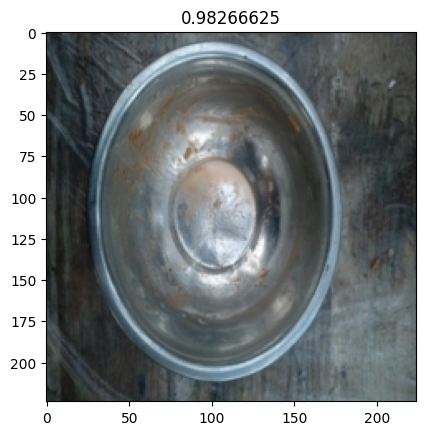

In [16]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

## Форматирование вывода

In [17]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [18]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.7 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('data/plates/test\\unknown\\', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

label
id         
0000  dirty
0001  dirty
0002  dirty
0003  dirty
0004  dirty
0005  dirty

In [19]:
submission_df.to_csv('data/submission.csv')